In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

import os
import itertools


import pandas as pd

from sklearn import svm, datasets, preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold

from scipy import interp
import seaborn as sns

import peakutils
import scipy.signal as sg
from scipy.signal import welch, butter, freqz, lfilter
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array, isnan, argwhere, argmax, argmin, fft, absolute
from statistics import mean, stdev, variance
from scipy.stats import kurtosis, skew
from pyentrp import entropy as ent
import operator

%matplotlib inline

In [2]:
subject_file_names = ["ID001","ID002","ID003","ID004","ID005",
                     "ID006","ID007","ID008","ID009","ID010",
                     "ID011","ID012","ID013","ID014","ID015",
                    "ID016","ID017","ID018","ID019","ID020"]

label_map = {"ID001": 1,"ID002": 2,"ID003": 3,"ID004": 4,"ID005": 5,
            "ID006": 6,"ID007":7,"ID008":8,"ID009":9,"ID010":10,
            "ID011":11,"ID012":12,"ID013":13,"ID014":14,"ID015":15,
            "ID016":16,"ID017":17,"ID018":18,"ID019":19,"ID020":20}

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

acc_f = open("Results/accelerometer_preprocessed_dataset_roc.csv","w+")
gyr_f = open("Results/gyroscope_preprocessed_dataset_roc.csv","w+")

acc_classes_f = open("Results/accelerometer_preprocessed_dataset_classes.csv","w+")
gyr_classes_f = open("Results/accelerometer_preprocessed_dataset_classes.csv","w+")

In [3]:
def signal_preprocessing(filename, label_index, command):
    list = []
    
    df_gait_file = pd.read_csv(filename, index_col="time").iloc[100:-100]
    df_gait_file.index *= 0.001

    #calculate magnitude
    df_gait_file["magnitude"] = np.sqrt(np.square(df_gait_file).sum(axis=1))
    
    #Interpolate the data using a cubic spline
    df_gait_file_spline = df_gait_file.reindex(np.arange(df_gait_file.index[0], df_gait_file.index[-1], 0.005), method="nearest", tolerance=0.002)
    df_gait_file_spline = df_gait_file_spline.interpolate(method="cubic").dropna()
    
    #Buterworth filter 
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    # Filter requirements.
    order = 5
    fs = 200.0       # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)
    
    df_gait_file_spline["filtered"] = butter_lowpass_filter(df_gait_file_spline["magnitude"], cutoff, fs, order)
    filtered = butter_lowpass_filter(df_gait_file_spline["magnitude"], cutoff, fs, order)

    col1 = df_gait_file_spline.index # First column data
    col2 = array(df_gait_file_spline["filtered"]) # Second column data
    
    #Optimal Threshold filter
    def find_optimal_threshold(t_low=0.2, t_high=1.0):
        """
        Finds the threshold as the one which minimises the standard deviation of the difference between peaks
        (normalised to the smallest value). 
        """
        optimal_threshold = 0.65
        closest_stdev = 10000.0
        for threshold in arange(t_low, t_high, 0.01):
            index = peakutils.indexes(-col2, thres=threshold, min_dist=20)
            index_diff = [index[i+1] - index[i] for i in range(len(index) - 1)]
            index_diff_norm = [float(idx)/min(index_diff) for idx in index_diff]
            if len(index_diff_norm) < 5:
                continue
            test_stdev = stdev(index_diff_norm)
            if test_stdev < closest_stdev:
                closest_stdev = test_stdev
                optimal_threshold = threshold
        return optimal_threshold
   
    thres = find_optimal_threshold()
    #print ("Optimal threshold = %s" % thres)
    index = peakutils.indexes(-col2, thres=thres, min_dist=80)
    #print('Peaks are: %s' % (index))
    
    index_diff = [index[i+1] - index[i] for i in range(len(index) - 1)]
    seg_mean, seg_stdev = mean(index_diff), stdev(index_diff)
    #print (seg_mean, seg_stdev)

    traces = []
    for i in range(len(index) - 1):
        if abs(index_diff[i] - seg_mean) > seg_stdev:
            continue
        traces.append(array(df_gait_file_spline["filtered"].iloc[index[i]:index[i+1]]))
        
    longest_trace_length = max([len(t) for t in traces])

    average_trace = []
    stdev_trace = []

    for i in range(longest_trace_length):
        vals = []
        for t in traces:
            try:
                vals.append(t[i])
            except IndexError:
                pass
        average_trace.append(mean(vals))
        try:
            stdev_trace.append(stdev(vals))
        except:
            stdev_trace.append(0.0)

    average_trace = array(average_trace)
    stdev_trace = array(stdev_trace)

    #Print features for all traces     
    if command == "append to accelerometer training file":
        for t in traces:
            std_t = np.std(t)
            A_k = fft.fft(t, 64)
            entropy = ent.sample_entropy(t, 8, 0.2 * std_t)    
            data =(','.join([str(i) for i in [max(t), min(t), mean(t), variance(t), kurtosis(t),
                                                  skew(t), argmax(t)*0.005 + argmin(t)*0.005, 
                                                 argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k),
                                                 entropy[0], entropy[1], entropy[2], entropy[3],
                                             entropy[4], entropy[5], entropy[6], entropy[7]]]))
            with open("Results/accelerometer_preprocessed_dataset_roc.csv","a+") as acc_f:
                acc_f.write(data + '\n')
                acc_f.close()
            with open("Results/accelerometer_preprocessed_dataset_classes.csv","a+") as acc_classes_f:
                acc_classes_f.write(str(label_index) + '\n')
                acc_classes_f.close()
                
    if command == "append to gyroscope training file":
        for t in traces:
            std_t = np.std(t)
            A_k = fft.fft(t, 64)
            entropy = ent.sample_entropy(t, 8, 0.2 * std_t)
            data =(','.join([str(i) for i in [max(t), min(t), mean(t), variance(t), kurtosis(t),
                                                  skew(t), argmax(t)*0.005 + argmin(t)*0.005, 
                                                 argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k),
                                                entropy[0], entropy[1], entropy[2], entropy[3],
                                             entropy[4], entropy[5], entropy[6], entropy[7]]]))
            with open("Results/gyroscope_preprocessed_dataset_roc.csv","a+") as gyr_f:
                gyr_f.write(data + '\n')
                gyr_f.close()
            with open("Results/gyroscope_preprocessed_dataset_classes.csv","a+") as gyr_classes_f:
                gyr_classes_f.write(str(label_index) + '\n')
                gyr_classes_f.close()

In [4]:
i = 0
for sfn in subject_file_names:
    print("PROCESSING " + sfn)
    signal_preprocessing("UJGaitDataset/accTrain/" + sfn + "-accelerometer01.csv", i, "append to accelerometer training file")
    signal_preprocessing("UJGaitDataset/accTest/" + sfn + "-accelerometer02.csv", i, "append to accelerometer training file")
    signal_preprocessing("UJGaitDataset/gyrTrain/" + sfn + "-gyroscope01.csv", i, "append to gyroscope training file")
    signal_preprocessing("UJGaitDataset/gyrTest/" + sfn + "-gyroscope02.csv", i, "append to gyroscope training file")
    i += 1

PROCESSING ID001
PROCESSING ID002
PROCESSING ID003
PROCESSING ID004
PROCESSING ID005
PROCESSING ID006
PROCESSING ID007
PROCESSING ID008
PROCESSING ID009
PROCESSING ID010
PROCESSING ID011
PROCESSING ID012
PROCESSING ID013
PROCESSING ID014
PROCESSING ID015
PROCESSING ID016
PROCESSING ID017
PROCESSING ID018
PROCESSING ID019
PROCESSING ID020


In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def calculateMetrics(sensor_name):
    with open("Results/" + sensor_name + "_preprocessed_dataset_classes.csv") as acc_classes_f:
        class_nums = acc_classes_f.readlines()
    class_nums = [x.strip() for x in class_nums] 

    for c in range(len(class_nums)):
        class_nums[c] = int(class_nums[c]) 

    classification_data = pd.read_csv("Results/" + sensor_name + "_preprocessed_dataset_roc.csv", 
                                          names=["a_max_amplitude", "a_min_amplitude", "a_mean",
                                                  "a_variance","a_kurtosis","a_skewness","a_pp_time",
                                                  "a_alar", "a_energy","a_entropy_1", "a_entropy_2", 
                                                 "a_entropy_3", "a_entropy_4","a_entropy_5", "a_entropy_6", 
                                                 "a_entropy_7", "a_entropy_8","label"])
    classification_data["logical_label"] = classification_data["label"].dropna().apply(lambda x: label_map[x])
    X = np.transpose(np.vstack((np.array(classification_data["a_max_amplitude"]), np.array(classification_data["a_min_amplitude"]),
                            np.array(classification_data["a_mean"]), np.array(classification_data["a_variance"]),
                           np.array(classification_data["a_kurtosis"]), np.array(classification_data["a_skewness"]),
                           np.array(classification_data["a_pp_time"]), np.array(classification_data["a_alar"]),
                           np.array(classification_data["a_energy"]), np.array(classification_data["a_entropy_1"]),
                               np.array(classification_data["a_entropy_2"]), np.array(classification_data["a_entropy_3"]),
                               np.array(classification_data["a_entropy_4"]), np.array(classification_data["a_entropy_5"]),
                               np.array(classification_data["a_entropy_6"]), np.array(classification_data["a_entropy_7"]),
                               np.array(classification_data["a_entropy_8"]))))

    X_scaled = preprocessing.scale(X)
    
    y = class_nums
    y = label_binarize(class_nums, classes=labels)
    n_classes = y.shape[1]
    means = X.mean(axis=0)
    stdevs = X.std(axis=0)


    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.5, random_state=0)
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + sensor_name+ ' sensor')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=subject_file_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=subject_file_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

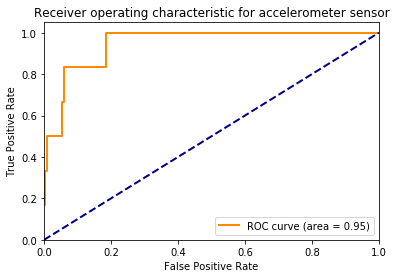

Confusion matrix, without normalization
Normalized confusion matrix


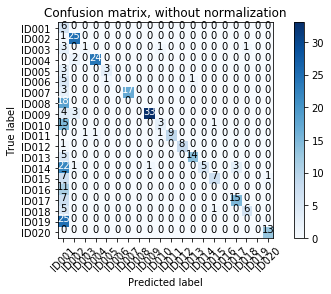

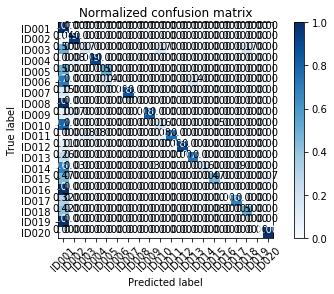

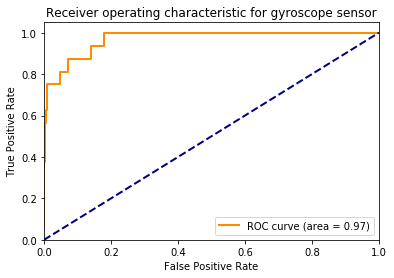

Confusion matrix, without normalization
Normalized confusion matrix


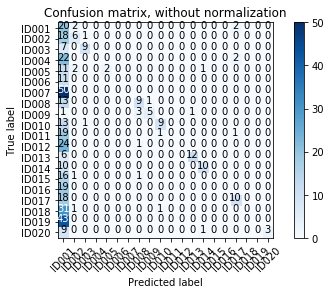

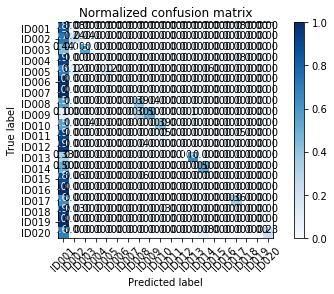

In [10]:
calculateMetrics("accelerometer")
calculateMetrics("gyroscope")